# Gradient Operator Visualization

In [1]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
from timeit import default_timer
from scipy.io import loadmat

sys.path.append("../")

from pcno.pcno import compute_Fourier_modes, compute_gradient

torch.set_printoptions(precision=16)

# Darcy problem

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


data = np.load("../data/darcy_2d/geokno_quad_equal_weight_data.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]
    


print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges)
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))



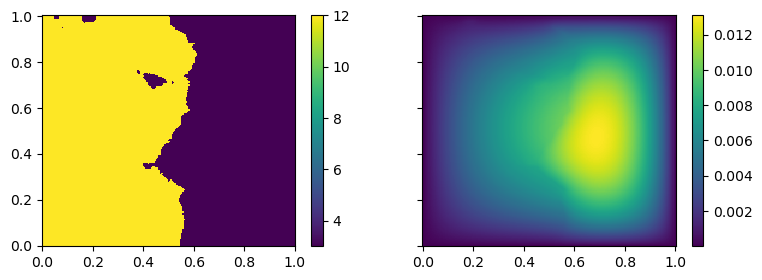

In [19]:
Np = 211
ind = 0
fig, axs = plt.subplots(1, 2, figsize=(9,3), sharex=True, sharey=True)
for i in range(2):
    pcm = axs[i].pcolormesh(nodes[ind,:,0].reshape((Np,Np)), nodes[ind,:,1].reshape((Np,Np)), features[ind,:,i].reshape((Np,Np)))
    fig.colorbar(pcm, ax=axs[i])

In [11]:
n_test = 3
gradient = compute_gradient(features[0:n_test,...].permute(0,2,1), directed_edges[0:n_test,...], edge_gradient_weights[0:n_test,...])

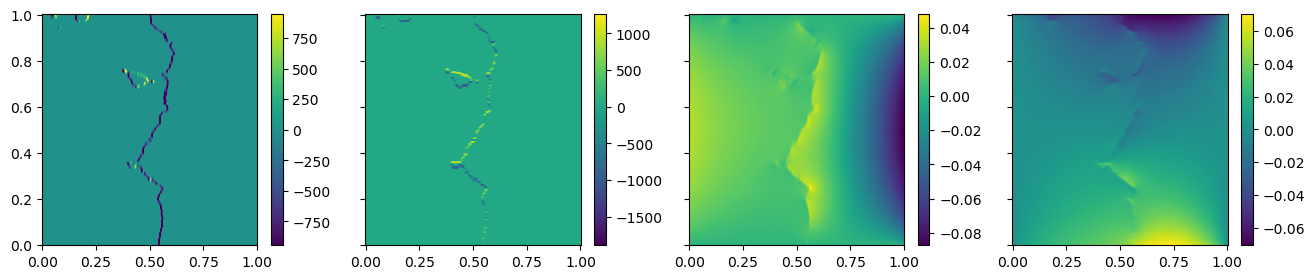

In [20]:
Np = 211
ind = 0
fig, axs = plt.subplots(1, 4, figsize=(16,3), sharex=True, sharey=True)
for i in range(4):
    pcm = axs[i].pcolormesh(nodes[ind,:,0].reshape((Np,Np)), nodes[ind,:,1].reshape((Np,Np)), gradient[ind,i,:].reshape((Np,Np)))
    fig.colorbar(pcm, ax=axs[i])


# Airfoil problem

In [22]:
data = np.load("../data/airfoil/geokno_quad_equal_weight_data.npz")
nnodes, node_mask, nodes, node_weights, features, directed_edges, edge_gradient_weights = data["nnodes"], data["node_mask"], data["nodes"], data["node_weights"], data["features"], data["directed_edges"], data["edge_gradient_weights"]


###################################
# prepare data
###################################

print("Casting to tensor")
nnodes = torch.from_numpy(nnodes)
node_mask = torch.from_numpy(node_mask)
nodes = torch.from_numpy(nodes.astype(np.float32))
node_weights = torch.from_numpy(node_weights.astype(np.float32))
features = torch.from_numpy(features.astype(np.float32))
directed_edges = torch.from_numpy(directed_edges)
edge_gradient_weights = torch.from_numpy(edge_gradient_weights.astype(np.float32))

Casting to tensor


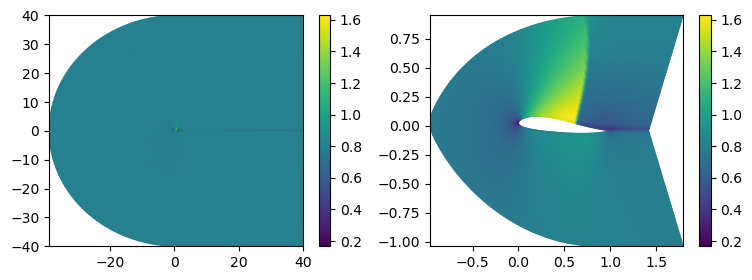

In [46]:
Npx, Npy = 221, 51
ind = 5
fig, axs = plt.subplots(1, 2, figsize=(9,3), sharex=False, sharey=False)
pcm = axs[0].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy)), nodes[ind,:,1].reshape((Npx, Npy)), features[ind,:,0].reshape((Npx, Npy)), shading="gouraud")
fig.colorbar(pcm, ax=axs[0])


cny, cnx = 40, 30 # how many layer to compute 
pcm = axs[1].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy))[cnx:-cnx, 0:cny], nodes[ind,:,1].reshape((Npx, Npy))[cnx:-cnx, 0:cny], features[ind,:,0].reshape((Npx, Npy))[cnx:-cnx, 0:cny], shading="gouraud")
fig.colorbar(pcm, ax=axs[1])

In [28]:
n_test = 3
gradient = compute_gradient(features[0:n_test,...].permute(0,2,1), directed_edges[0:n_test,...], edge_gradient_weights[0:n_test,...])

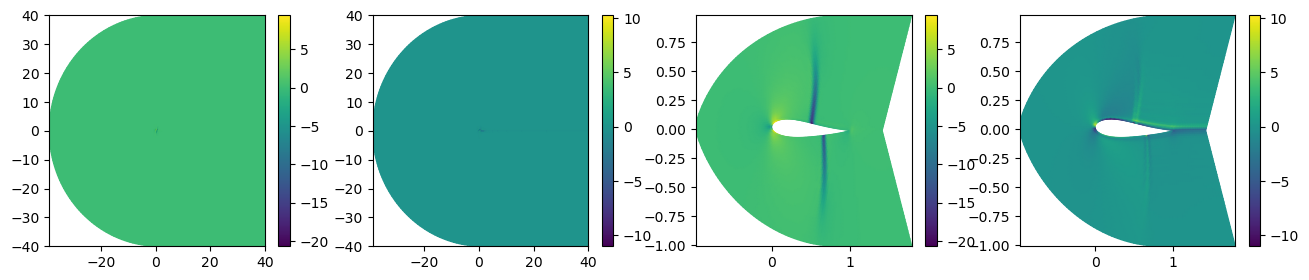

In [48]:
Npx, Npy = 221, 51
Np = 211
ind = 0
fig, axs = plt.subplots(1, 4, figsize=(16,3), sharex=False, sharey=False)
for i in range(2):
    pcm = axs[i].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy)), nodes[ind,:,1].reshape((Npx, Npy)), gradient[ind,i,:].reshape((Npx, Npy)), shading="gouraud")
    fig.colorbar(pcm, ax=axs[i])

cny, cnx = 40, 30 # how many layer to compute 
for i in range(2):
    pcm = axs[i+2].pcolormesh(nodes[ind,:,0].reshape((Npx, Npy))[cnx:-cnx, 0:cny], nodes[ind,:,1].reshape((Npx, Npy))[cnx:-cnx, 0:cny], gradient[ind,i,:].reshape((Npx, Npy))[cnx:-cnx, 0:cny], shading="gouraud")
    fig.colorbar(pcm, ax=axs[i+2])
